# Breast Cancer Detection 



### Import ML packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import seaborn as sns

%matplotlib inline

## Exploratory Analysis

### Read and load Dataset

In [ ]:
# Load Data
df = pd.read_csv('sample_data/data.csv')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [ ]:
#Shape of the Dataset
df.shape

(569, 33)

In [ ]:
df.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,0.0
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,NaN
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,NaN
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,NaN
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,NaN
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,NaN
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,NaN
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,NaN


## Data pre-processing

In [ ]:
#set the ID column to be the index of the dataframe
df = df.set_index('id')

In [ ]:
df.drop(['Unnamed: 32'],axis=1,inplace= True)

In [ ]:
# Columns in the dataset
df.columns

Index(['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

## Encoding Categorical Data

In [ ]:
#Enumerate the diagnosis column such that M = 1, B = 0 
df['diagnosis'] = df['diagnosis'].apply(lambda x: '1' if x == 'M' else '0')
df['diagnosis'] = df['diagnosis'].astype("float64")

In [ ]:
#The number of Benign and Maglinant cases from the dataset.
print(df.groupby('diagnosis').size())

diagnosis
0.0    357
1.0    212
dtype: int64


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 569 entries, 842302 to 92751
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    float64
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se            

In [ ]:
# get the number of missing data points per column
missing_values_count = df.isnull().sum()
missing_values_count[0:10]

diagnosis              0
radius_mean            0
texture_mean           0
perimeter_mean         0
area_mean              0
smoothness_mean        0
compactness_mean       0
concavity_mean         0
concave points_mean    0
symmetry_mean          0
dtype: int64

## Data Visualization

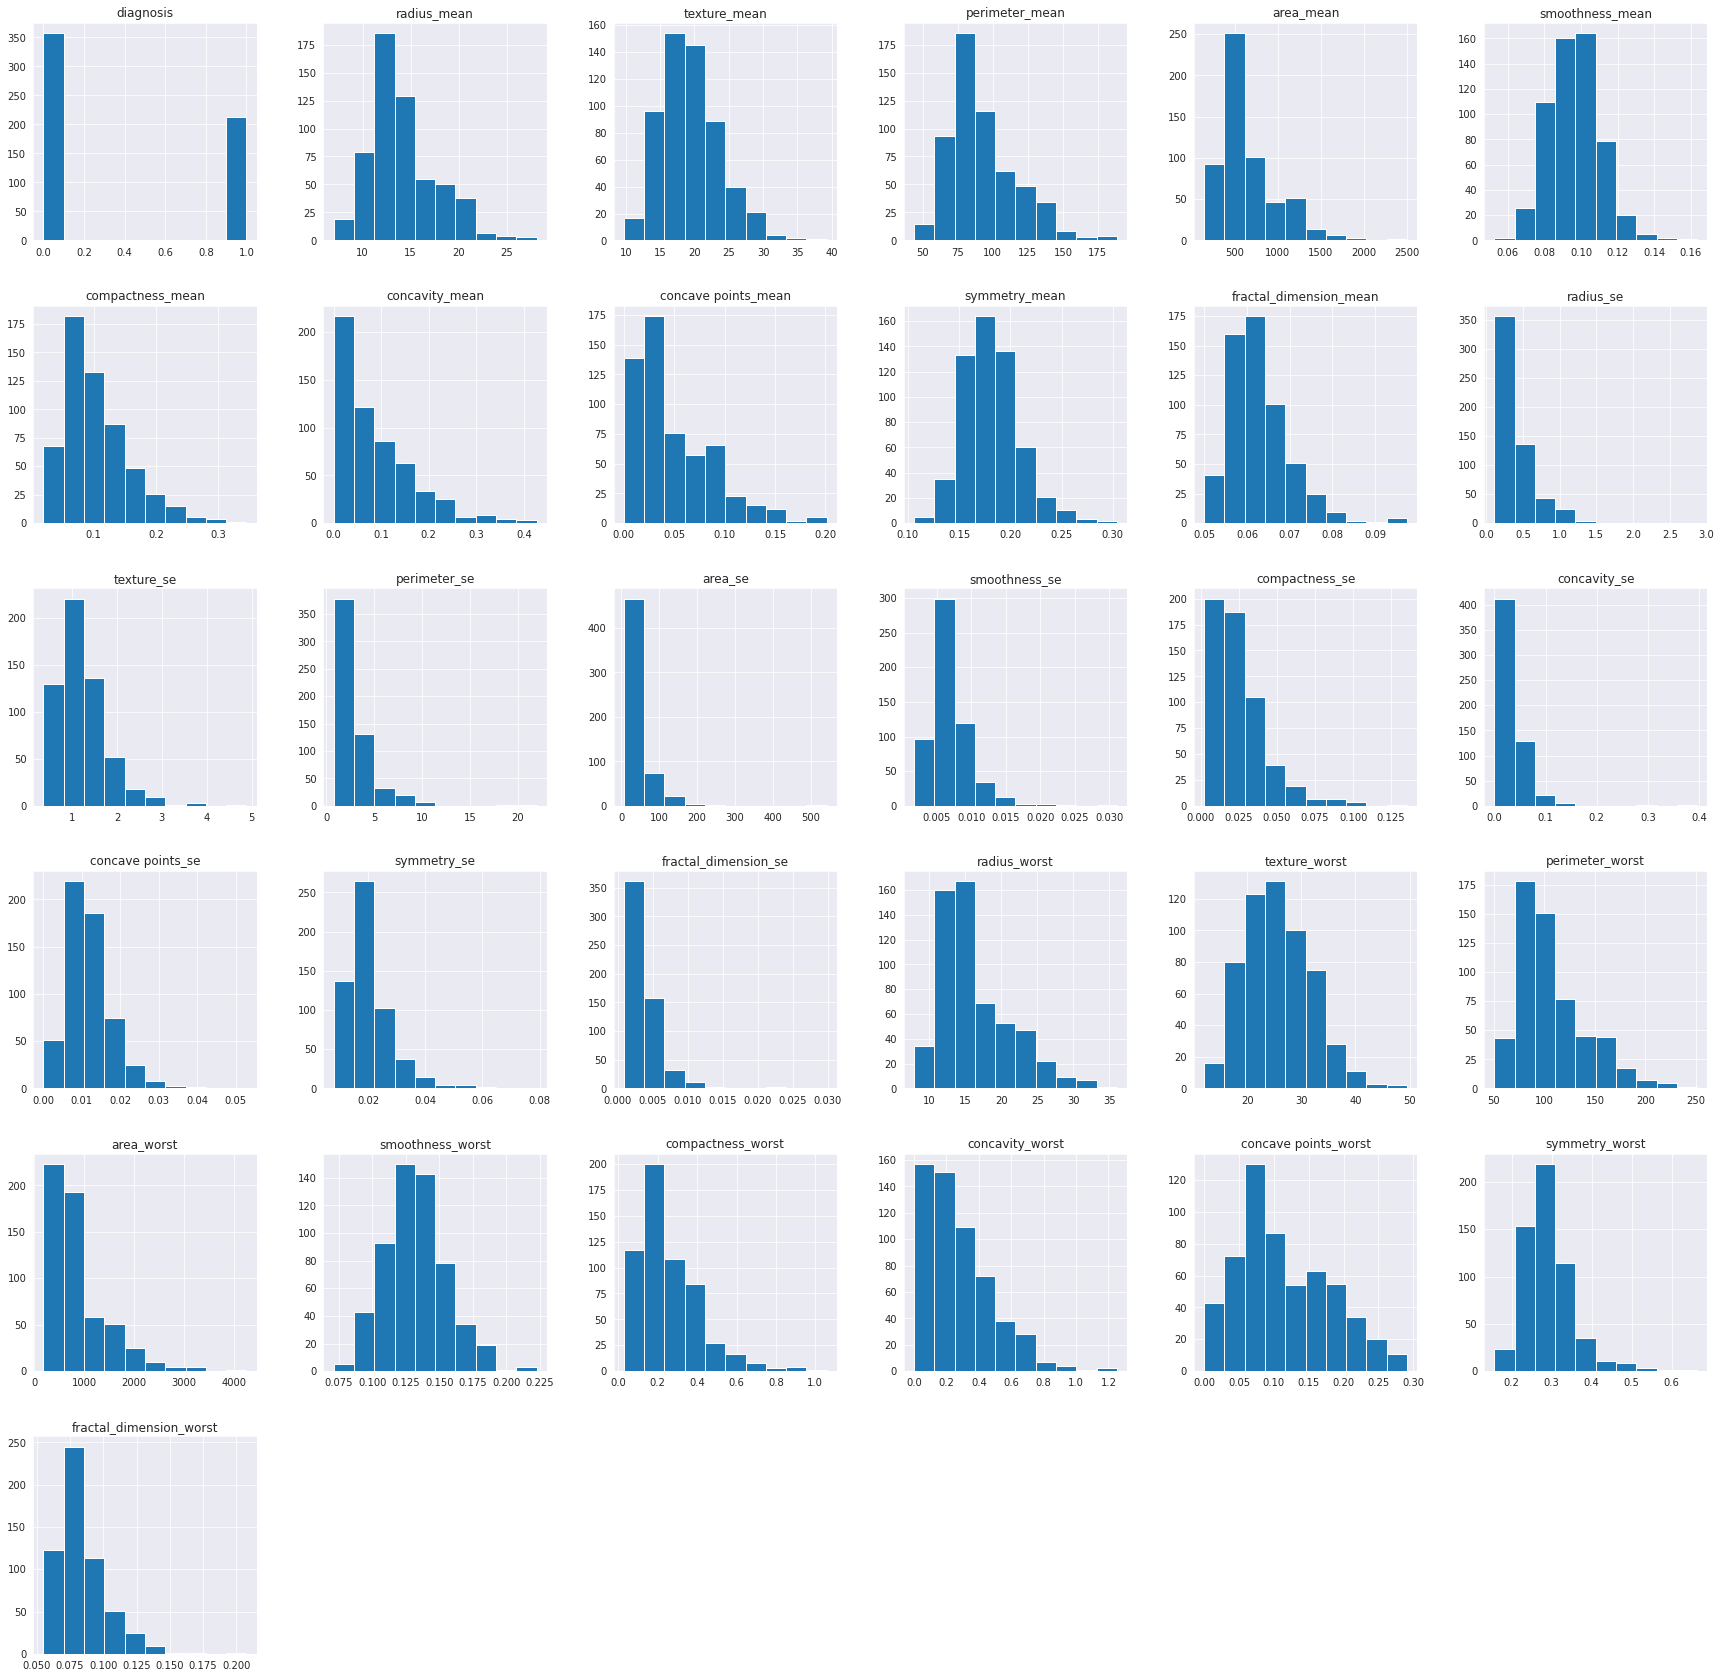

In [ ]:
# Plot histograms for each variable
sns.set_style('darkgrid')
df.hist(figsize=(30,30))
plt.show()

## Feature selection

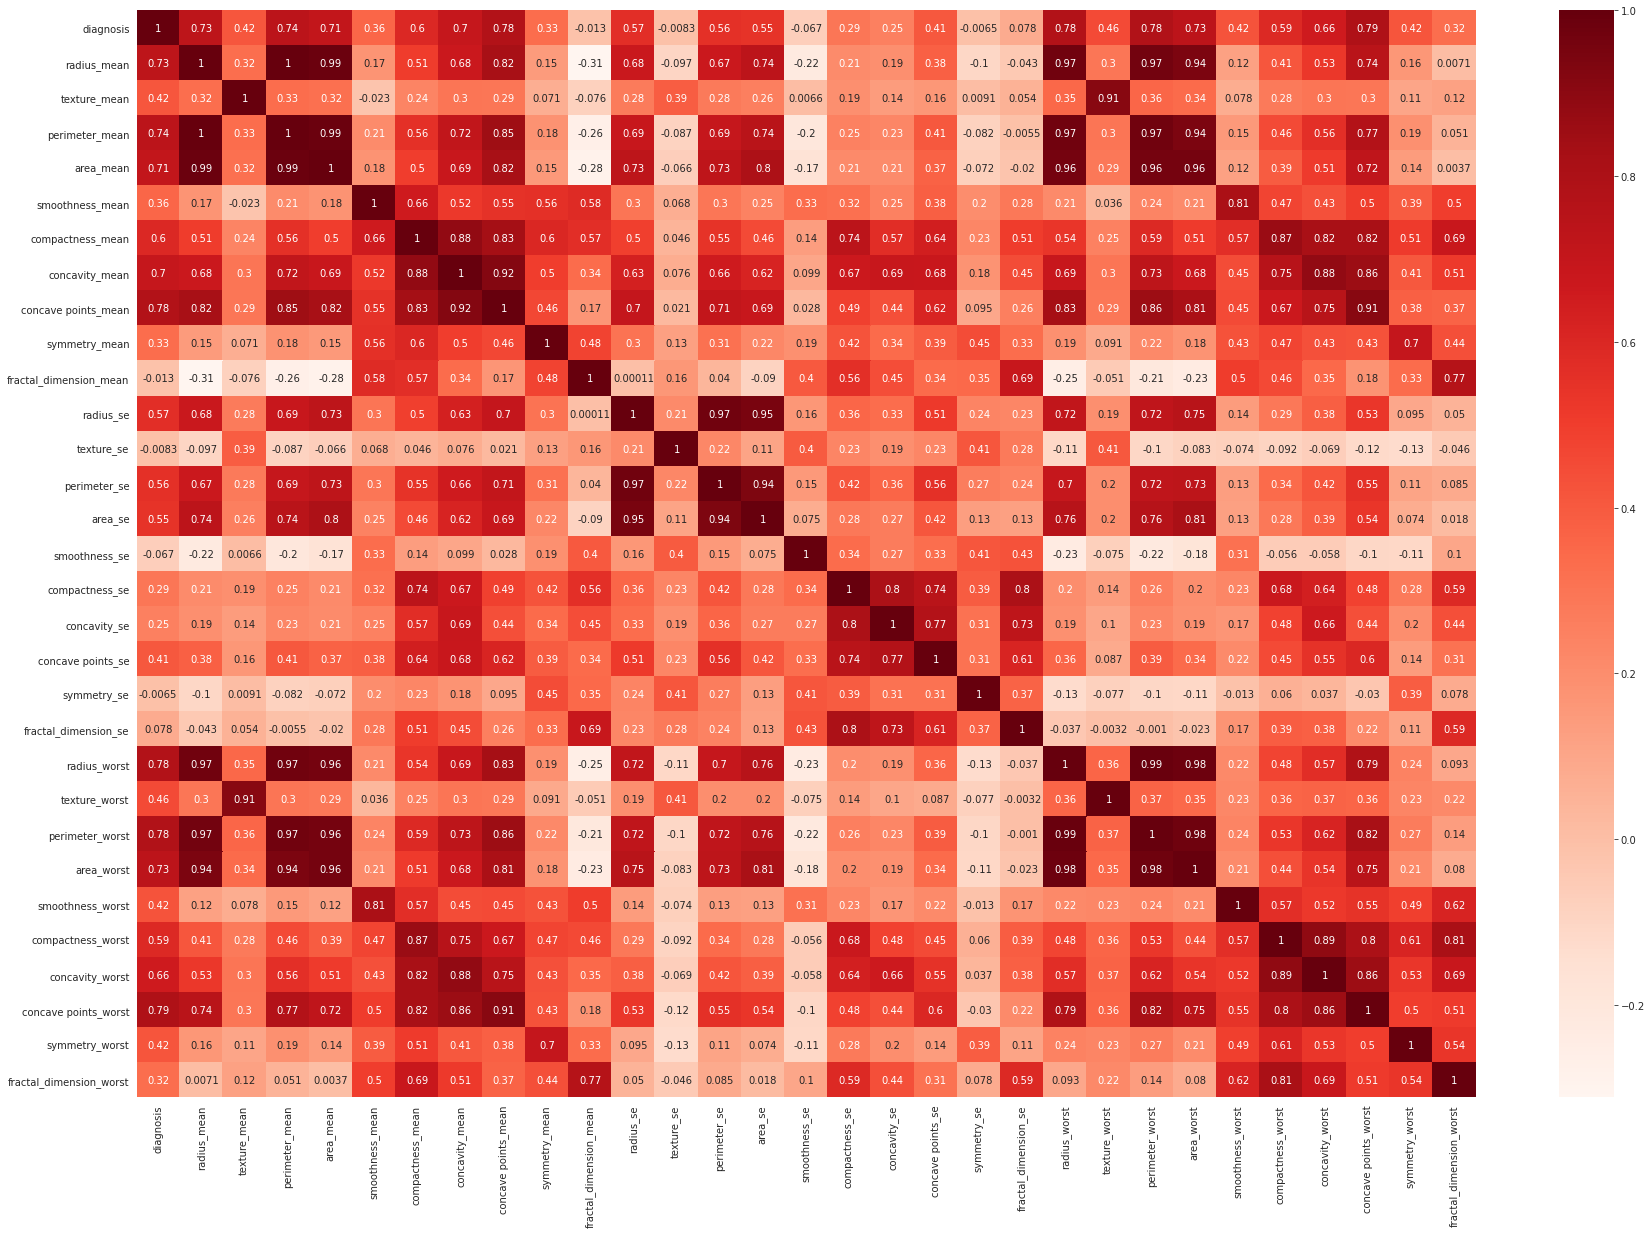

In [ ]:
plt.figure(figsize=(30,20))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
#Correlation with output variable
cor_target = abs(cor["diagnosis"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.7]
relevant_features

diagnosis               1.000000
radius_mean             0.730029
perimeter_mean          0.742636
area_mean               0.708984
concave points_mean     0.776614
radius_worst            0.776454
perimeter_worst         0.782914
area_worst              0.733825
concave points_worst    0.793566
Name: diagnosis, dtype: float64

## Train and Test Model

In [ ]:
#Split the data into predictor variables and target variable, following by breaking them into train and test sets. 

Y = df['diagnosis'].values
X = df.drop('diagnosis', axis=1).values

X_train, X_test, Y_train, Y_test = train_test_split (X, Y, test_size = 0.20, random_state=21)

## Model Selection
### Baseline algorithm checking

* Analyse and build a model to predict if a given set of symptoms lead to breast cancer. This is a binary classification problem, and a few algorithms are appropriate for use. 

* As we do not know which one will perform the best at the point, we will do a quick test on the few appropriate algorithms with default setting to get an early indication of how each of them perform. 

* We will use 10 fold cross validation for each testing.

* The following non-linear algorithms will be used, namely: 
  * Classification and Regression Trees (CART) 
  * Linear Support Vector Machines (SVM)
  * Gaussian Naive Bayes (NB) 
  * k-Nearest Neighbors (KNN).

In [ ]:
# Testing Options
scoring = 'accuracy'

In [ ]:
# Define models to train
models= []
models.append(('CART', DecisionTreeClassifier()))
models.append(('SVM', SVC())) 
models.append(('NB', GaussianNB()))
models.append(('KNN', KNeighborsClassifier()))

# evaluate each model in turn
results = []
names = []

for name, model in models:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "For %s Model:Mean accuracy is %f (Std accuracy is %f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

For CART Model:Mean accuracy is 0.918744 (Std accuracy is 0.036918)
For SVM Model:Mean accuracy is 0.907681 (Std accuracy is 0.054723)
For NB Model:Mean accuracy is 0.940773 (Std accuracy is 0.033921)
For KNN Model:Mean accuracy is 0.927729 (Std accuracy is 0.055250)


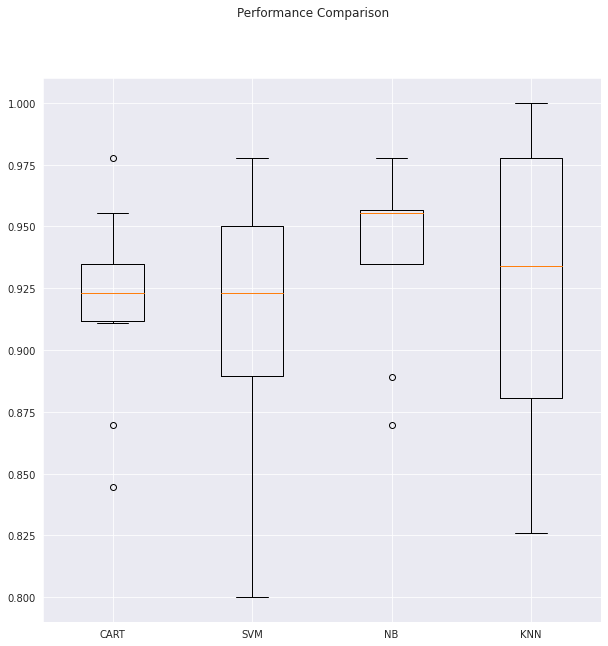

In [ ]:
fig = plt.figure(figsize=(10,10))
fig.suptitle('Performance Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

From the initial run, it looks like CART, SVM, GaussianNB and KNN  performed the best with  above 90% mean accuracy.


## Evaluation of algorithm on Standardised Data

Using pipelines to improve the performance of all machine learning algorithms by using standardised dataset  The improvement is likely for all the models. 

In [ ]:
# Standardize the dataset
import warnings
pipelines = []

pipelines.append(('Scaled CART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeClassifier())])))
pipelines.append(('Scaled SVM', Pipeline([('Scaler', StandardScaler()),('SVM', SVC( ))])))
pipelines.append(('Scaled NB', Pipeline([('Scaler', StandardScaler()),('NB', GaussianNB())])))
pipelines.append(('Scaled KNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsClassifier())])))

results = []
names = []

kfold = KFold(n_splits= 10)
for name, model in pipelines:
  cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
  results.append(cv_results)
  names.append(name)
  print( "For %s Model: Mean Accuracy is %f (Std Accuracy is %f)" % (name, cv_results.mean(), cv_results.std()))

For Scaled CART Model: Mean Accuracy is 0.914300 (Std Accuracy is 0.031875)
For Scaled SVM Model: Mean Accuracy is 0.964879 (Std Accuracy is 0.038621)
For Scaled NB Model: Mean Accuracy is 0.931932 (Std Accuracy is 0.038625)
For Scaled KNN Model: Mean Accuracy is 0.958357 (Std Accuracy is 0.038595)


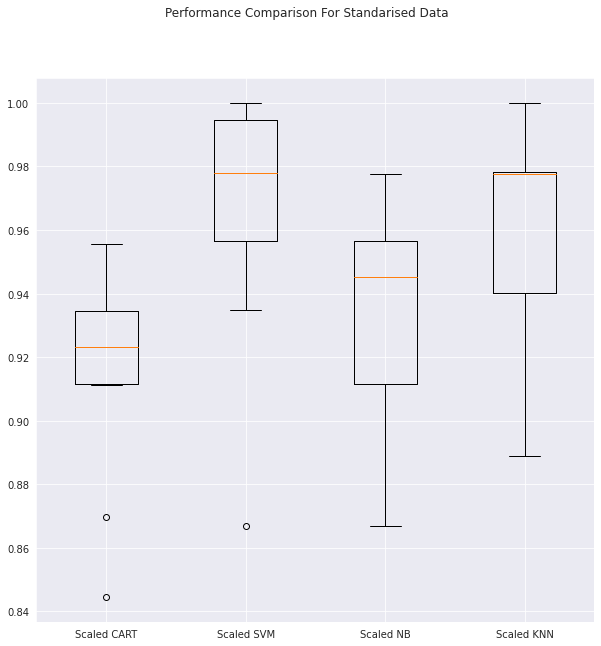

In [ ]:
fig = plt.figure(figsize=(10,10))
fig.suptitle('Performance Comparison For Standarised Data')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [ ]:
# Make predictions on validation dataset

for name, model in models:
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    model.fit(X_train_scaled, Y_train)
    X_test_scaled = scaler.transform(X_test)
    predictions = model.predict(X_test_scaled)
    print("\nModel:",name)
    print("Accuracy score:" % accuracy_score(Y_test, predictions))
    print("Classification report:\n",classification_report(Y_test, predictions))
    print("Confusion Matrix:\n",confusion_matrix(Y_test, predictions))
    
    
# Accuracy - ratio of correctly predicted observation to the total observations. 
# Precision - (false positives) ratio of correctly predicted positive observations to the total predicted positive observations
# Recall (Sensitivity) - (false negatives) ratio of correctly predicted positive observations to the all observations in actual class - yes.
# F1 score - F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false 


Model: CART
Accuracy score:
Classification report:
               precision    recall  f1-score   support

         0.0       0.97      0.92      0.95        75
         1.0       0.86      0.95      0.90        39

    accuracy                           0.93       114
   macro avg       0.92      0.93      0.92       114
weighted avg       0.93      0.93      0.93       114

Confusion Matrix:
 [[69  6]
 [ 2 37]]

Model: SVM
Accuracy score:
Classification report:
               precision    recall  f1-score   support

         0.0       0.99      0.99      0.99        75
         1.0       0.97      0.97      0.97        39

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114

Confusion Matrix:
 [[74  1]
 [ 1 38]]

Model: NB
Accuracy score:
Classification report:
               precision    recall  f1-score   support

         0.0       0.95      0.96      0.95        75
     